Generate mock skewers from the TreePM L=256Mpc/h simulation box. This uses the set of mock skewers generated by Alex Krolewski for his cosmic void analysis which includes realistic noise and continuum errors.

We then do the following: 

1. Reorganize the skewers to 'surveys' with the same 30Mpc/h x 24Mpc/h footprint as CLAMATO. This allows approximately 8 x 10 surveys in the volume
2. Repeat each skewer at its end to create 512Mpc/h skewers, which is more than the 2.0<z<2.6 range used in the xcorr analysis
3. Introduce the pixel masks from the real data, so that there is realistic masking in the mock skewers. This will also automatically trim the skewers
4. Save in the same format and coordinate system as the real data.

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table

from astropy.cosmology import FlatLambdaCDM, z_at_value

from fnmatch import fnmatch

np.random.seed(6260665)

# Define cosmology. To set the conversion between [RA,Dec] and [x,y], we assume <z>=2.3
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)
zmin = 2.0
zmid = 2.3
comdist_mean = cosmo.comoving_distance(zmid)
comdist_zmin = cosmo.comoving_distance(zmin)
dcomdist_dz = cosmo.inv_efunc(zmid) *2998. # in Mpc/h

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline


#Read in the skewers, which are in 5-dimensional arrays of [x,y,z,noise,delta_F]
skewers_orig = np.fromfile('allskewers_512cubed_46058nskew.bin')
skewers = np.reshape(skewers_orig, (int(np.shape(skewers_orig)[0]/5), 5))
npixels = int(np.shape(skewers_orig)[0]/5)

np.shape(skewers)

(13448936, 5)

In [2]:
# Separate the pixels into individual skewers
xpos_pix= skewers[:,0]
ypos_pix= skewers[:,1]
zpos_pix= skewers[:,2]
sigma_pix = skewers[:,3]
flux_pix = skewers[:,4]

xy_pix = np.transpose([xpos_pix, ypos_pix])
pos_arr = [tuple(xytmp) for xytmp in xy_pix]
xy_uniq_arr = np.unique(pos_arr, axis=0)

xy_uniq = [tuple(xytmp) for xytmp in xy_uniq_arr]

n_skewer = len(xy_uniq)
npix_perskewer = np.int(npixels/ n_skewer)

print('{0} noisy skewers being processed'.format(n_skewer))


46058 noisy skewers being processed


In [3]:
print(npix_perskewer)

292


292
Working with 253 input skewers from CLAMATO
77 sightlines with coverage beyond max redshift
102 sightlines with coverage below min redshift
Maximum extent of sim skewer: 733.3136966126657 cMpc


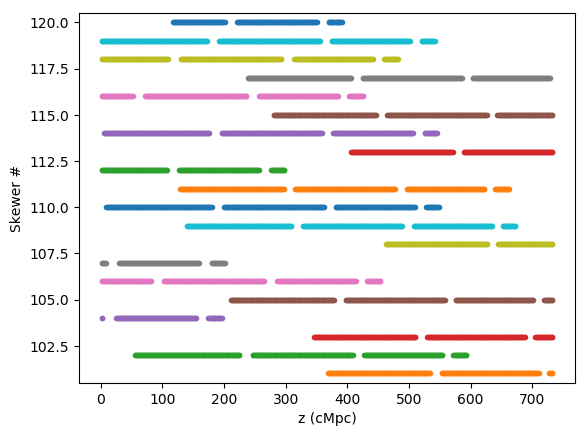

In [4]:
# Read in the CLAMATO data pixels, and create pixel masks relative to the 'long' sim skewers
print(npix_perskewer)

import lyafxcorr_kg as xcorr

def find_nearest_ind(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

clpix = xcorr.lyapix("pixel_radecz_cl2017_v4.1.bin",cosmo=cosmo) 

# Separate the pixels into individual skewers
skewerpos_cl , skewermask_cl = clpix.gen_SkewerRec()
comdis_cl = clpix.comdist
nskewer_cl = len(skewerpos_cl)

print('Working with {0} input skewers from CLAMATO'.format(nskewer_cl))

skewermask_real = [None] * nskewer_cl
zpos_1sim = zpos_pix[0:npix_perskewer]/cosmo.h
deltaz = zpos_1sim[1] - zpos_1sim[0]
zskewer_rep = zpos_1sim + np.max(zpos_1sim)+deltaz
zskewer_long = np.append(zpos_1sim, zskewer_rep)

# The masktmp here is to grab the relevant pixels out of the overall pixel class.
# Whereas the skewermask_real is the mask which would be applied to the simulated pixels
ctr = 0
count_hiz = 0
count_lowz = 0
for masktmp in skewermask_cl:
    # List of the z-values (in cMpc) in the current CLAMATO skewer
    compix_tmp = clpix.comdist[masktmp] - comdist_zmin  # in cMpc (no h)
    dcompix = compix_tmp[1:len(compix_tmp)] - compix_tmp[0:len(compix_tmp)-1]
    #Initialize boolean array for the current skewer
    mask_bool = np.full(2*npix_perskewer, True)
    #First, mask out pixels beyond the ends of the sightline
    if max(zskewer_long)*0.97 < np.max(compix_tmp.value):
        count_hiz += 1
    if max(zskewer_long)*0.03 > np.min(compix_tmp.value):
        count_lowz += 1
    mask_bool[zskewer_long < np.min(compix_tmp).value] = False
    mask_bool[zskewer_long > np.max(compix_tmp).value] = False
    #dcomdist = compix_tmp[1:len(compix_tmp)] - compix_tmp[0:len(compix_tmp-1)]
    biggap_ind = np.where(dcompix.value > 2.*np.median(dcompix.value))
    gap_ind, = biggap_ind
    if len(gap_ind) > 0: # the indices here refer to the CLAMATO skewers, but we need 
                         # to reference the sim skewers.... 
        for ii in gap_ind:
            npix_gap = np.int(np.round(dcompix[ii].value/deltaz))
            zgap_tmp = compix_tmp[ii].value
            isim = find_nearest_ind(zskewer_long, zgap_tmp)
            isim_max = min(isim+npix_gap+1,len(zskewer_long))
            mask_bool[np.arange(isim, isim_max)] = False
    # Next, look for gaps in the spectrum and mask those
    skewermask_real[ctr] = mask_bool
    ctr +=1

print('{0} sightlines with coverage beyond max redshift'.format(count_hiz))
print('{0} sightlines with coverage below min redshift'.format(count_lowz))    
print('Maximum extent of sim skewer: {0} cMpc'.format(max(zskewer_long+deltaz/2.)))

fig, ax = plt.subplots()

ax.set_ylim([100.5,120.5])
ax.set_xlabel('z (cMpc)')
ax.set_ylabel('Skewer #')

for i in np.arange(nskewer_cl):
    yval = np.full(2*npix_perskewer, np.float(i))
    mask_now= skewermask_real[i]
    ax.plot(zskewer_long[mask_now], yval[mask_now], marker='.', linewidth=0)
    
plt.show()

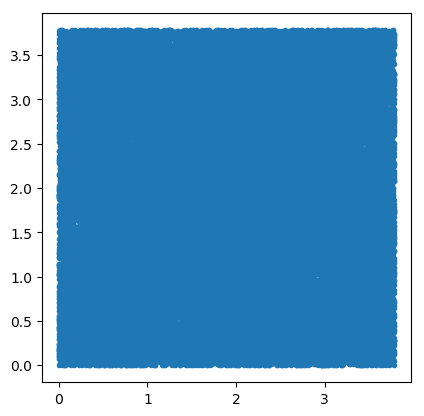

In [5]:

xskewer = np.asarray([tuptmp[0] for tuptmp in xy_uniq])
yskewer = np.asarray([tuptmp[1] for tuptmp in xy_uniq])

#Assign RA and Dec corresponding to x and y
ra_skewer = 180./np.pi  * xskewer/comdist_mean.value/cosmo.h
dec_skewer = 180./np.pi * yskewer/comdist_mean.value/cosmo.h

radec_uniq = list(zip(ra_skewer, dec_skewer))

coords = list(zip(xskewer, yskewer, ra_skewer, dec_skewer))

fig, ax = plt.subplots()
ax.set_aspect('equal')
np.shape(xy_uniq)
pl = ax.scatter(ra_skewer, dec_skewer, marker='.')
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
plt.show()



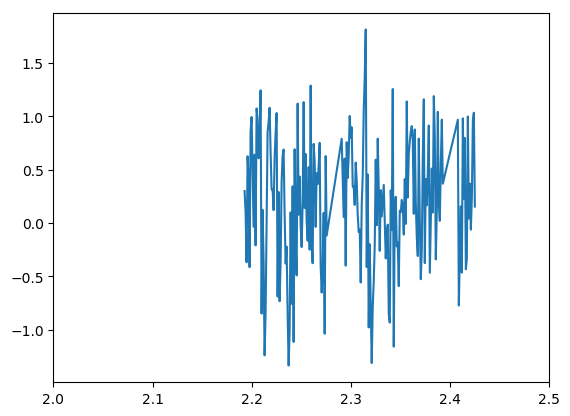

In [6]:
# Grab one sightline just to test

xtmp , ytmp = xy_uniq[24051]

skewer_mask = np.all(np.column_stack([np.isclose(xtmp, xpos_pix,rtol=1.e-5),
                 np.isclose(ytmp, ypos_pix, rtol=1.e-5)]),axis=1)

zskewer = zpos_pix[skewer_mask]
flux = flux_pix[skewer_mask]

deltaz = zskewer[1]-zskewer[0]

zskewer_rep = zskewer + max(zskewer)+deltaz
zskewer_long = np.append(zskewer, zskewer_rep)

flux_long = np.append(flux,flux)

iskewer_tmp = np.asscalar(np.random.choice(nskewer_cl,1))

pixmask_tmp = skewermask_real[iskewer_tmp]

#flux_long[np.invert(pixmask_tmp)] = 0. # for illustrative purposes only

redshift= zmin + zskewer_long[pixmask_tmp]/dcomdist_dz

fig,ax = plt.subplots()
ax.plot(redshift, flux_long[pixmask_tmp])

ax.set_xlim([2.,2.5])
plt.show()

In [7]:
import time

# Generate mock survey data sets. 

# We will create mocks over these number of distinct fields
nmock_x = 8
nmock_y = 10
nmocks = nmock_x * nmock_y

width_x = 30. # Mpc/h
width_y = 24. # Mpc/h

# Generate tuples indicating the field boundaries and center
xlow_field = np.arange(nmock_x)*width_x
xhi_field = (np.arange(nmock_x) + 1.)*width_x 
xcen_field = np.ndarray.tolist((xlow_field+xhi_field)/2.)
xlow_field = np.ndarray.tolist(xlow_field)
xhi_field = np.ndarray.tolist(xhi_field)
xboundaries = list(zip(xlow_field, xcen_field, xhi_field))

ylow_field = np.arange(nmock_y) * width_y
yhi_field  = (np.arange(nmock_y)+1.)* width_y
ycen_field = np.ndarray.tolist((ylow_field+yhi_field)/2.)
ylow_field = np.ndarray.tolist(ylow_field)
yhi_field = np.ndarray.tolist(yhi_field)
yboundaries = list(zip(ylow_field, ycen_field, yhi_field))

# Loop over the fields
ctr = 1
for xlow_tmp, xcen_tmp, xhi_tmp in xboundaries:
    for ylow_tmp, ycen_tmp, yhi_tmp in yboundaries: # all this in Mpc/h
        # Grab skewers within this field, this is the mask for the arrays of x and y
        getskewers = np.all(np.column_stack([(xskewer > xlow_tmp),
                                            (xskewer <= xhi_tmp),
                                            (yskewer > ylow_tmp),
                                            yskewer <= yhi_tmp]), axis=1)
        xlist_2x = xskewer[getskewers]
        ylist_2x = yskewer[getskewers]
        ralist_2x = ra_skewer[getskewers]
        declist_2x = dec_skewer[getskewers]
        nskew_tmp = np.sum(getskewers)
        
        # Randomly grab half the skewers
        getskew_ind = np.squeeze(np.nonzero(getskewers)) # Indices of all skewers
        getskew_ind1 = np.random.choice(getskew_ind, np.int(np.round(nskew_tmp/2.)), replace=False)
        
        getskewers[getskew_ind1] = False # Switch to false skewers selected in first set
        getskew_ind2 = np.squeeze(np.nonzero(getskewers))
        
        nskew_tmp1 = len(getskew_ind1)
        nskew_tmp2 = len(getskew_ind2)
        
        ra_vec1 = [] #np.asarray([None])
        dec_vec1 = [] #np.asarray([None])
        z_vec1 = [] #np.asarray([None])
        sig_vec1 = [] #np.asarray([None])
        f_vec1 = [] #np.asarray([None])
        
        coord_tmp1 = zip(xskewer[getskew_ind1], yskewer[getskew_ind1], 
                         ra_skewer[getskew_ind1], dec_skewer[getskew_ind1])
        
        tstart = time.time()
        for xtmp, ytmp, ra_tmp, dec_tmp in coord_tmp1:
            #print(xtmp, ytmp)
            skewer_mask = np.all(np.column_stack([np.isclose(xtmp, xpos_pix,rtol=1.e-5),
                                                  np.isclose(ytmp, ypos_pix, rtol=1.e-5)]),
                                 axis=1)

            zskewer = zpos_pix[skewer_mask]
            flux = flux_pix[skewer_mask]
            sigma = sigma_pix[skewer_mask]

            deltaz = zskewer[1]-zskewer[0]

            zskewer_rep = zskewer + max(zskewer)+deltaz
            redshift_vec = zmin + np.append(zskewer,zskewer_rep)/dcomdist_dz 
            
            flux_long = np.append(flux,flux)
            sigma_long = np.append(sigma, sigma)
            

            icl = np.asscalar(np.random.choice(nskewer_cl, 1))
            pixmask_tmp = skewermask_real[icl]
            
            npix_thisskewer = np.sum(pixmask_tmp)
            
            ra_vec_tmp  = npix_thisskewer * [np.asscalar(ra_tmp)]
            dec_vec_tmp = npix_thisskewer * [np.asscalar(dec_tmp)]
            
            red_tmp = np.ndarray.tolist(redshift_vec[pixmask_tmp])
            flux_tmp = np.ndarray.tolist(flux_long[pixmask_tmp])
            sigma_tmp = np.ndarray.tolist(sigma_long[pixmask_tmp])
            
            #ra_vec1=   np.append(ra_vec1, ra_vec_tmp)
            #dec_vec1=   np.append(dec_vec1, dec_vec_tmp)
            #z_vec1=    np.append(z_vec1, red_tmp)
            #f_vec1=    np.append(f_vec1, flux_tmp)
            #sig_vec1=   np.append(sig_vec1, sigma_tmp)
            
            ra_vec1.extend(ra_vec_tmp)
            dec_vec1.extend(dec_vec_tmp)
            z_vec1.extend(red_tmp)
            sig_vec1.extend(sigma_tmp)
            f_vec1.extend(flux_tmp)
        
        npix_thismock = np.asarray(len(ra_vec1), dtype='i4')
        ra_sav1 = np.asarray(ra_vec1,dtype='f8')
        dec_sav1 = np.asarray(dec_vec1,dtype='f8')
        z_sav1  = np.asarray(z_vec1,dtype='f8')
        sig_sav1 = np.asarray(sig_vec1,dtype='f8')
        f_sav1 = np.asarray(f_vec1,dtype='f8')
            
        print('Time to generate one mock = {0}s'.format(time.time()-tstart))
        if ctr ==1:
            break
        
    if ctr == 1:
        break


Time to generate one mock = 159.9594657421112s


In [8]:
print(npix_thismock)
outname1 = 'pixel_radecz_mock_{0:03d}.bin'.format(ctr)
pixfile1 = open(outname1,"w")

npix_thismock = np.asarray(npix_thismock, dtype='i4')
npix_thismock.tofile(pixfile1)
ra_sav1.tofile(pixfile1)
dec_sav1.tofile(pixfile1)
z_sav1.tofile(pixfile1)
sig_sav1.tofile(pixfile1)
f_sav1.tofile(pixfile1)

pixfile1.close()

74714


In [9]:
print(np.sum(np.isnan(ra_sav1)))
print(ra_sav1[0:99])

0
[ 0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826  0.27842826
  0.27842826  0.27842826  0.27842826  0.27842826 